# Infection régionale française avec le nouveau coronavirus (SRAS-CoV-2), COVID-19

Sante Publique France fournit les taux quotidiens [confirmés d'infection](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde) au niveau régional. Toutefois, ces taux sont fournis sous la forme d'un tableau statique unique sans historique.

Je les ai compilés en une série chronologique et je vais essayer de les tenir à jour pendant la pandémie. N'hésitez pas à les utiliser comme vous le souhaitez. Code publié sous licence BSD-3 et tout le reste comme CC-By.

Shapefiles de [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/contours-geographiques-des-nouvelles-regions-metropole/).

Exigences: Pandas, Matplotlib, GeoPandas, GeoPlot

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from matplotlib import pyplot as plt

In [52]:
data_file = "data/covid-19-data.csv"
df = pd.read_csv(data_file)
# Filtrer par date limite
latest_date = df["Date"].max()
df[df["Date"] == latest_date].head(14)

,Région,Date,Cas-confirmés
308,Auvergne-Rhône-Alpes,2020-03-24,1857
309,Bourgogne-Franche-Comté,2020-03-24,1510
310,Bretagne,2020-03-24,526
311,Centre-Val de Loire,2020-03-24,450
312,Corse,2020-03-24,217
313,Grand Est,2020-03-24,4922
314,Hauts-de-France,2020-03-24,1532
315,Ile-de-France,2020-03-24,6798
316,Normandie,2020-03-24,586
317,Nouvelle-Aquitaine,2020-03-24,789


## Carte des points

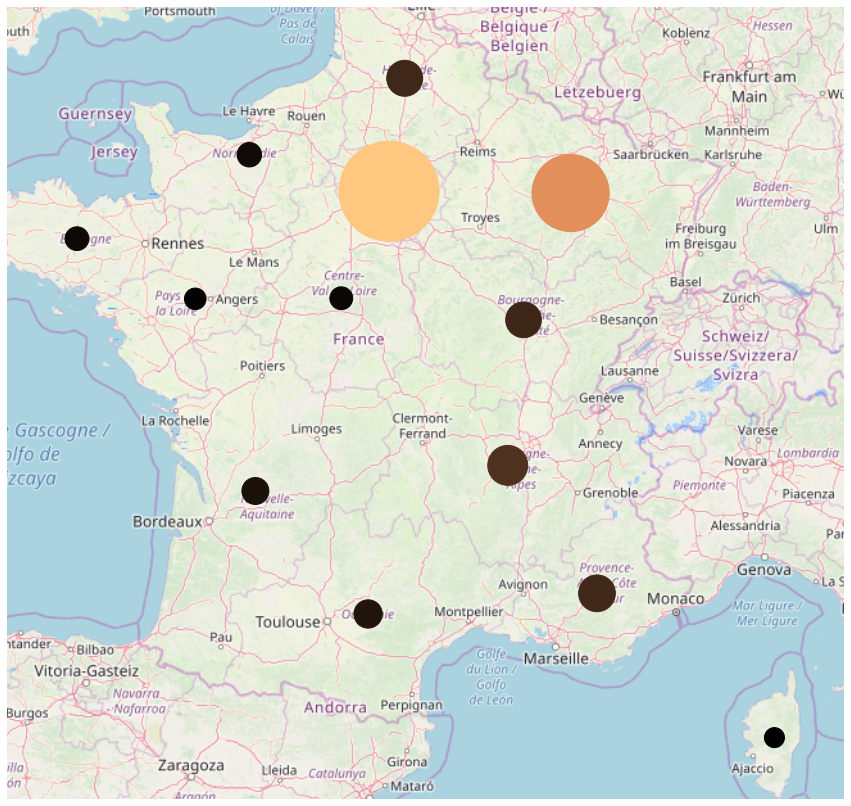

In [53]:
# Ouvrez le fichier "shapefile" appelé "contours-geographiques-des-nouvelles-regions-metropole.shp" 
# et notez que - si vous faites cela chez vous ordinateur, vous devrez charger le fichier à partir 
# de l'endroit où vous l'avez enregistré
shape_data = gpd.GeoDataFrame.from_file("data/contours-geographiques-des-nouvelles-regions-metropole.shp")
regions = {"Grand-Est": "Grand Est",
           "Bourgogne-Franche-ComtÃ©": "Bourgogne-Franche-Comté", 
           "Auvergne-RhÃ´ne-Alpes": "Auvergne-Rhône-Alpes", 
           "Provence-Alpes-CÃ´te d'Azur": "Provence-Alpes-Côte d’Azur", 
           "Nouvelle Aquitaine": "Nouvelle-Aquitaine"
          }
shape_data["region"] = shape_data["region"].replace(regions)
boundaries = pd.merge(shape_data, df[df["Date"] == latest_date], 
                      how="outer", 
                      left_on="region", 
                      right_on="Région", 
                      indicator=True)
boundaries = boundaries[boundaries["_merge"]=="both"]

centroidseries = shape_data['geometry'].centroid
centroids = shape_data.copy()
centroids["geometry"] = centroidseries

centroids = pd.merge(centroids, df[df["Date"] == latest_date], 
                     how="outer", 
                     left_on="region", 
                     right_on="Région", 
                     indicator=True)
centroids = centroids[centroids["_merge"]=="both"]

ax = gplt.webmap(boundaries, 
                 projection=gcrs.WebMercator(), 
                 figsize=(15,15))
gplt.pointplot(centroids,
               projection=gcrs.AlbersEqualArea(),
               scale="Cas-confirmés", limits=(20, 100),
               hue="Cas-confirmés", cmap="copper",
               ax=ax)

## Graphiques linéaires

Text(0.5, 0.98, 'Régional France COVID-19 cumulatif cas-confirmés depuis 2020-03-24')

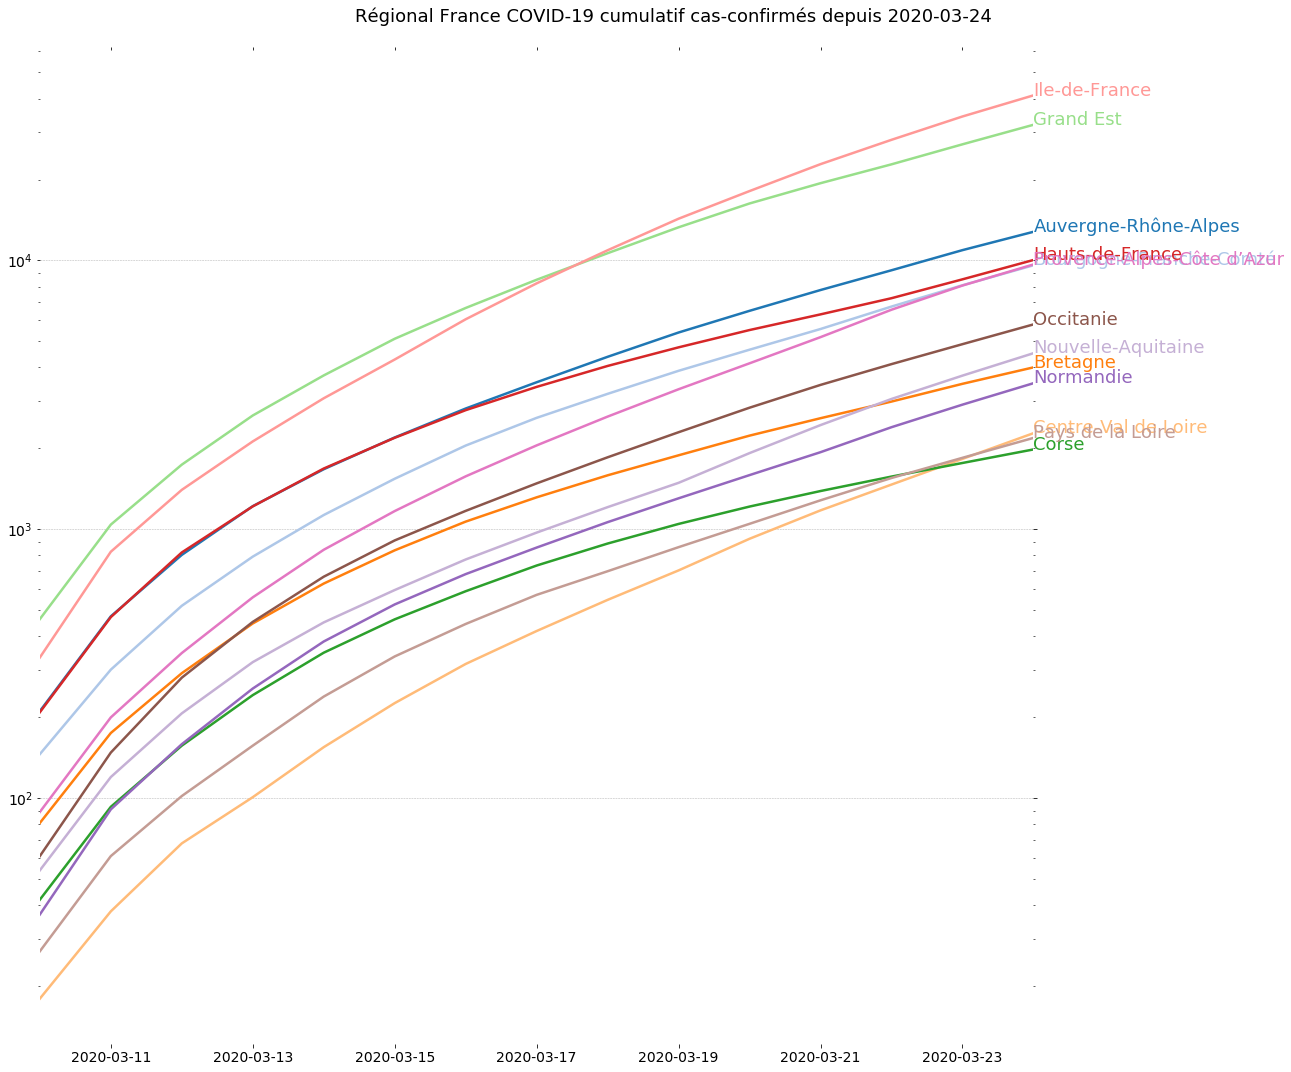

In [57]:
df["Cumulatif-cas-confirmés"] = df.groupby("Région")["Cas-confirmés"].cumsum()
df["Date"] = pd.to_datetime(df.Date)
data_min = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-cas-confirmés"].min(),-1))
data_max = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-cas-confirmés"].max(),-1))
drawing = pd.pivot_table(df[df["Région"].isin(boundaries["Région"])],
                         values="Cumulatif-cas-confirmés",
                         index=["Date"],
                         columns=["Région"])
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
ax.set_xlim(drawing.index.min().date(), drawing.index.max().date())
#ax.set_ylim(data_min, data_max)
ax.set_yscale("log")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')
for n, column in enumerate(drawing.columns):
    line = plt.plot(drawing.index,
                    drawing[column],
                    lw=2.5,
                    color=color_sequence[n])
    y_pos = drawing[column][-1] - 0.05
    plt.text(drawing.index.max().date(), y_pos, column, fontsize=18, color=color_sequence[n])
title = F"Régional France COVID-19 cumulatif cas-confirmés depuis {drawing.index.max().date().isoformat()}"
fig.suptitle(title, fontsize=18, ha='center')

## Région infection doublant le temps

Référence : [Lisa Charlotte Rost, DataWrapper](https://blog.datawrapper.de/weekly-chart-coronavirus-doublingtimes/)

In [58]:
import math
from datetime import datetime, timedelta
from tabulate import tabulate

def doubling_time(x, y, z):
    """
    x est le temps qui s'est écoulé depuis que vous avez commencé à mesurer. 
        Par exemple, si le nombre de cas est passé de 500 le jour 0 à 1000 le jour 2, x est égal à 2.
    y est le nombre de cas au jour x, par exemple 1000 au jour 2.
    z est le nombre de cas au jour 0, par exemple 500.
    """
    return (x*math.log(2))/(math.log(y/z))

N = 5
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j av.",
           "chg.",
           F"n. cas ({N}j)",
           F"{N}j av.",
           "chg."
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_N - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulatif-cas-confirmés"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulatif-cas-confirmés"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulatif-cas-confirmés"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulatif-cas-confirmés"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if (double_N / double_2N) - 1 >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if (double_2N / double_N) - 1 >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if (case_N / case_2N) - 1 >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if (case_2N / case_N) - 1 >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        F"{double_N:.2f}", F"{double_2N:.2f}", double_change,
        F"{case_N:,}", F"{case_2N:,}", case_change
    ])
    
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

╒════════════════════════════╤═════════════════╤══════════╤════════╤═══════════════╤══════════╤════════╕
│ Région                     │   t. dbler (5j) │   5j av. │ chg.   │ n. cas (5j)   │ 5j av.   │ chg.   │
╞════════════════════════════╪═════════════════╪══════════╪════════╪═══════════════╪══════════╪════════╡
│ Auvergne-Rhône-Alpes       │            4.02 │     2.96 │ ▲      │ 7,385         │ 3,723    │ ▲▲     │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Bourgogne-Franche-Comté    │            3.84 │     2.81 │ ▲      │ 5,708         │ 2,757    │ ▲▲     │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Bretagne                   │            4.6  │     3.16 │ ▲      │ 2,118         │ 1,257    │ ▲▲     │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Centre-Val de Loire        │            2.95 │     2.

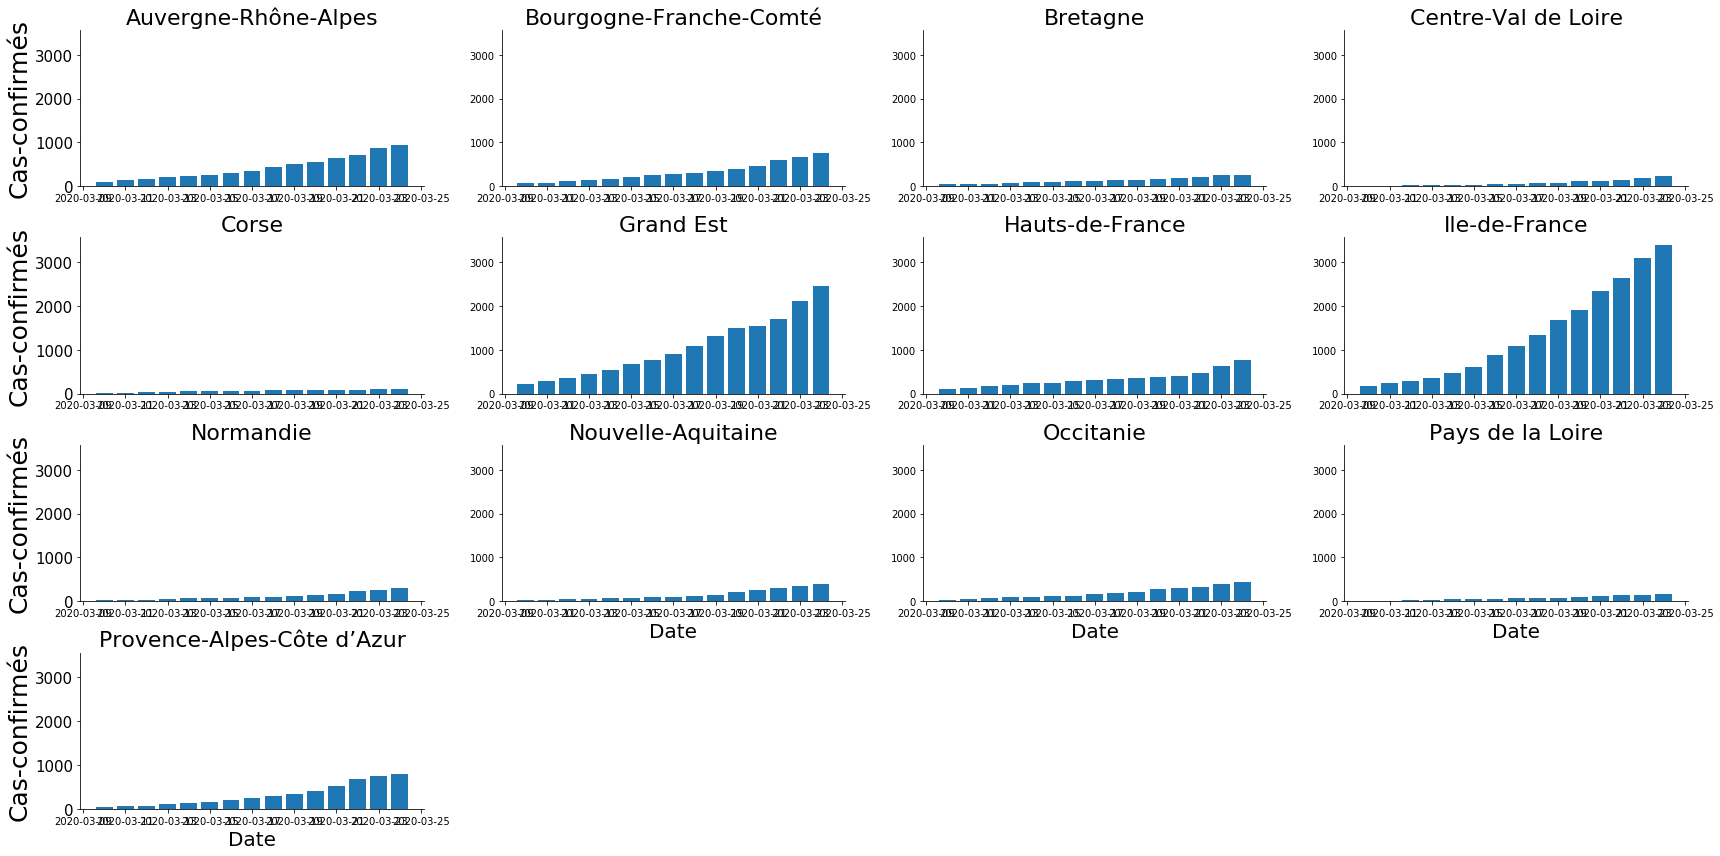

In [59]:
# https://stackoverflow.com/a/54031113
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
        
sm = sns.FacetGrid(df[df["Région"].isin(boundaries["Région"])],
                      col="Région", 
                      col_wrap=4, size=3, 
                      aspect=2, 
                      margin_titles=True)
sm = sm.map(plt.bar, "Date", "Cas-confirmés")

sm.set_titles("{col_name}", size=22).set_ylabels(size=25).set_yticklabels(size=15)\
                                    .set_xlabels(size=20).set_xticklabels(size=10)
sm.fig.tight_layout(w_pad=2)

## Cumulé de personnes décédées

In [61]:
data_file = "data/covid-19-data-decedees.csv"
df = pd.read_csv(data_file)
# Filtrer par date limite
latest_date = df["Date"].max()
df[df["Date"] == latest_date]

,Région,Date,Cumulé de personnes décédées
108,Guadeloupe,2020-03-24,0
109,Martinique,2020-03-24,1
110,Guyane,2020-03-24,0
111,La Réunion,2020-03-24,0
112,Mayotte,2020-03-24,0
113,Île-de-France,2020-03-24,262
114,Centre-Val de Loire,2020-03-24,9
115,Bourgogne-Franche-Comté,2020-03-24,85
116,Normandie,2020-03-24,15
117,Hauts-de-France,2020-03-24,109


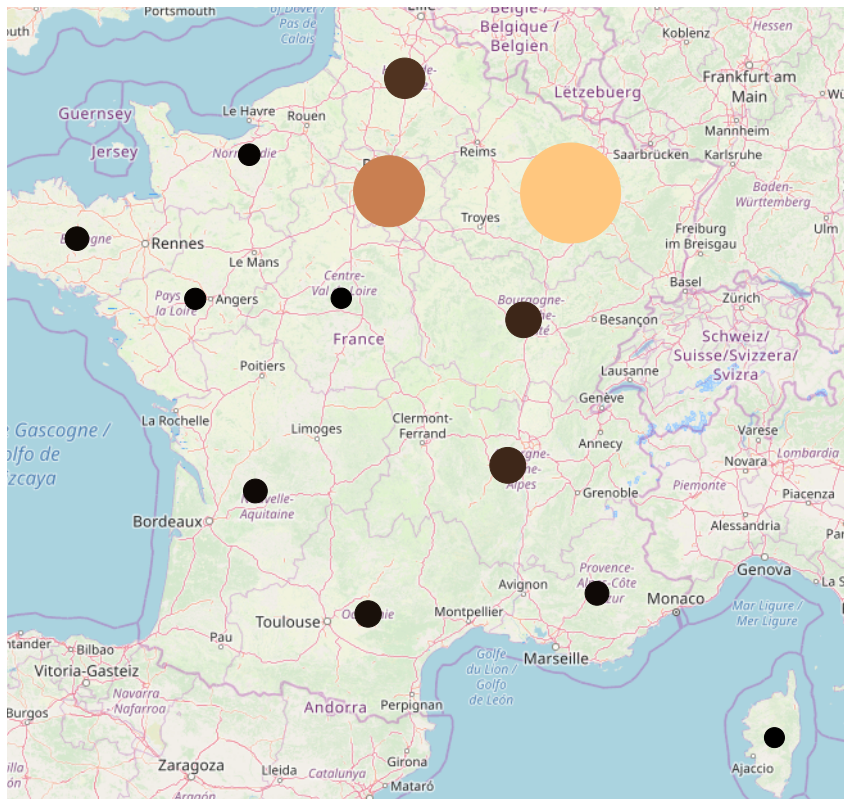

In [62]:
# Ouvrez le fichier "shapefile" appelé "contours-geographiques-des-nouvelles-regions-metropole.shp" 
# et notez que - si vous faites cela chez vous ordinateur, vous devrez charger le fichier à partir 
# de l'endroit où vous l'avez enregistré
shape_data = gpd.GeoDataFrame.from_file("data/contours-geographiques-des-nouvelles-regions-metropole.shp")
regions = {"Grand-Est": "Grand-Est",
           "Bourgogne-Franche-ComtÃ©": "Bourgogne-Franche-Comté", 
           "Auvergne-RhÃ´ne-Alpes": "Auvergne-Rhône-Alpes", 
           "Provence-Alpes-CÃ´te d'Azur": "Provence-Alpes-Côte d'Azur", 
           "Nouvelle Aquitaine": "Provence-Alpes-Côte d'Azur",
           "Ile-de-France": "Île-de-France"
          }
shape_data["region"] = shape_data["region"].replace(regions)
boundaries = pd.merge(shape_data, df[df["Date"] == latest_date], 
                      how="outer", 
                      left_on="region", 
                      right_on="Région", 
                      indicator=True)
boundaries = boundaries[boundaries["_merge"]=="both"]
centroidseries = shape_data['geometry'].centroid
centroids = shape_data.copy()
centroids["geometry"] = centroidseries

centroids = pd.merge(centroids, df[df["Date"] == latest_date], 
                     how="outer", 
                     left_on="region", 
                     right_on="Région", 
                     indicator=True)
centroids = centroids[centroids["_merge"]=="both"]
ax = gplt.webmap(boundaries, 
                 projection=gcrs.WebMercator(), 
                 figsize=(15,15))
gplt.pointplot(centroids,
               projection=gcrs.AlbersEqualArea(),
               scale="Cumulé de personnes décédées", limits=(20, 100),
               hue="Cumulé de personnes décédées", cmap="copper",
               ax=ax)

Text(0.5, 0.98, 'Régional France COVID-19 nombre cumulé de personnes décédées depuis 2020-03-24')

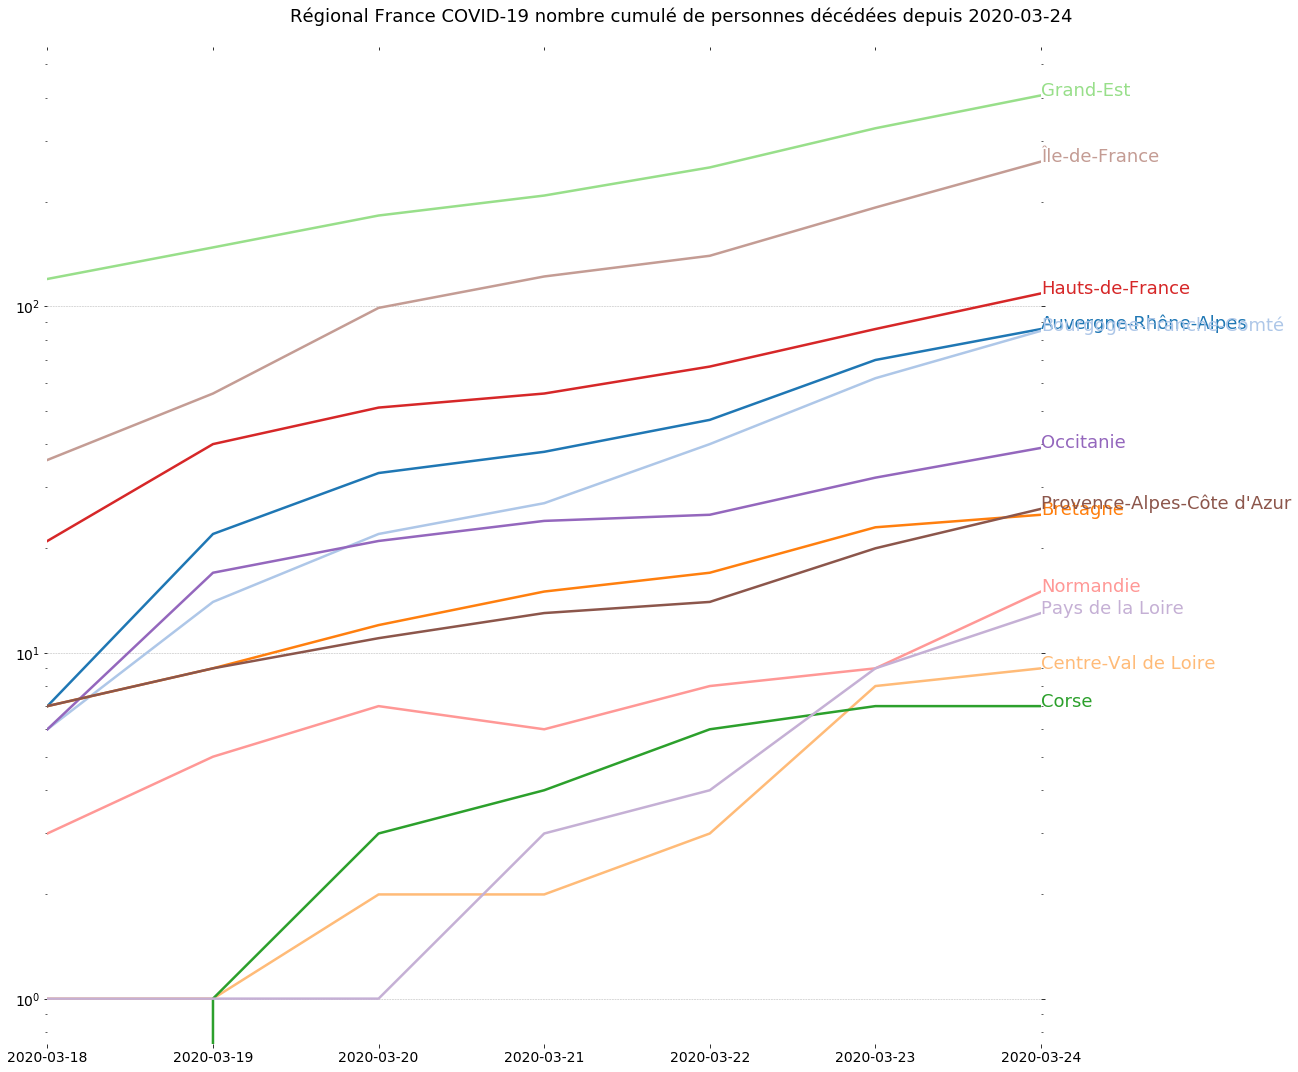

In [63]:
# https://matplotlib.org/examples/showcase/bachelors_degrees_by_gender.html
df["Date"] = pd.to_datetime(df.Date)
data_min = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulé de personnes décédées"].min(),-1))
data_max = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulé de personnes décédées"].max(),-1))
drawing = pd.pivot_table(df[df["Région"].isin(boundaries["Région"])],
                         values="Cumulé de personnes décédées",
                         index=["Date"],
                         columns=["Région"])
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
ax.set_xlim(drawing.index.min().date(), drawing.index.max().date())
#ax.set_ylim(data_min, data_max)
ax.set_yscale("log")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')
for n, column in enumerate(drawing.columns):
    line = plt.plot(drawing.index,
                    drawing[column],
                    lw=2.5,
                    color=color_sequence[n])
    y_pos = drawing[column][-1] - 0.05
    plt.text(drawing.index.max().date(), y_pos, column, fontsize=18, color=color_sequence[n])
title = F"Régional France COVID-19 nombre cumulé de personnes décédées depuis {drawing.index.max().date().isoformat()}"
fig.suptitle(title, fontsize=18, ha='center')

In [64]:
import math
from datetime import datetime, timedelta
from tabulate import tabulate

def doubling_time(x, y, z):
    """
    x est le temps qui s'est écoulé depuis que vous avez commencé à mesurer. 
        Par exemple, si le nombre de cas est passé de 500 le jour 0 à 1000 le jour 2, x est égal à 2.
    y est le nombre de cas au jour x, par exemple 1000 au jour 2.
    z est le nombre de cas au jour 0, par exemple 500.
    """
    return (x*math.log(2))/(math.log(y/z))

N = 2
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j av.",
           "chg.",
           F"n. cas ({N}j)",
           F"{N}j av.",
           "chg."
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_N - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulé de personnes décédées"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulé de personnes décédées"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulé de personnes décédées"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulé de personnes décédées"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if (double_N / double_2N) - 1 >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if (double_2N / double_N) - 1 >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if (case_N / case_2N) - 1 >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if (case_2N / case_N) - 1 >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        F"{double_N:.2f}", F"{double_2N:.2f}", double_change,
        F"{case_N:,}", F"{case_2N:,}", case_change
    ])
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

╒════════════════════════════╤═════════════════╤══════════╤════════╤═══════════════╤══════════╤════════╕
│ Région                     │   t. dbler (2j) │   2j av. │ chg.   │   n. cas (2j) │   2j av. │ chg.   │
╞════════════════════════════╪═════════════════╪══════════╪════════╪═══════════════╪══════════╪════════╡
│ Auvergne-Rhône-Alpes       │            2.29 │     3.92 │ ▼▼     │            39 │       14 │ ▲▲     │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Bourgogne-Franche-Comté    │            1.84 │     2.32 │ ▼      │            45 │       18 │ ▲▲     │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Bretagne                   │            3.59 │     3.98 │ ▼      │             8 │        5 │ ▲▲     │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Centre-Val de Loire        │            1.26 │     3.

## Choroplèthe & expériences 

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
boundaries.plot(ax=ax, column="Cas-confirmés", cmap="OrRd")

In [ ]:
# https://stackoverflow.com/a/54031113
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def facetgrid_two_axes(*args, **kwargs):
    data = kwargs.pop("data")
    dual_axis = kwargs.pop("dual_axis")
    alpha = kwargs.pop("alpha", 0.2)
    kwargs.pop("color")
    ax = plt.gca()
    if dual_axis:
        ax2 = ax.twinx()
        ax2.set_ylabel("Cumulatif-cas-confirmés")
    # https://github.com/matplotlib/matplotlib/issues/13142/#issuecomment-453174700
    ax.bar(data["Date"], data["Cas-confirmés"], **kwargs, color='red',alpha=alpha,
           width=np.timedelta64(12, 'h'))
    if dual_axis:
        ax2.plot(data["Date"], data["Cumulatif-cas-confirmés"], **kwargs, color='blue',alpha=alpha)
        
sm = sns.FacetGrid(df[df["Région"].isin(boundaries["Région"])],
                      col="Région", 
                      col_wrap=4, size=3, 
                      aspect=2, 
                      margin_titles=True)
#sm = sm.map(plt.bar, "Date", "Cas-confirmés")
#sm = sm.map(plt.plot, "Date", "Cumulatif-cas-confirmés").set(yscale ='log')
sm = sm.map_dataframe(facetgrid_two_axes, dual_axis=True)\
       .set_axis_labels("Date", "Cas-confirmés")

sm.set_titles("{col_name}", size=22).set_ylabels(size=25).set_yticklabels(size=15)\
                                    .set_xlabels(size=20).set_xticklabels(size=10)
sm.fig.tight_layout(w_pad=2)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

population_file = "data/France-population.csv"
pf = pd.read_csv(population_file)
chunks = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    d = pf[pf["Région"]==name]["Population"].values[0] / 1000
    region.loc[:, "Cumulatif-cas-confirmés"] = region.apply(lambda x: x["Cumulatif-cas-confirmés"]/d, 
                                                            axis=1)
    chunks.append(region)
pf = pd.concat(chunks)
drawing = pd.pivot_table(pf,
                         values="Cumulatif-cas-confirmés",
                         index=["Date"],
                         columns=["Région"])
fig, ax = plt.subplots(figsize=(20,15))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.set_ylabel("Cumulatif Cas-confirmés / mille", size=25)
ax.set_xlabel("Date", size=20)
drawing.plot(grid=True, logy=True, fontsize=14, ax=ax)
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, fontsize=14, title_fontsize="large")

In [ ]:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

dfs = df[df["Région"].isin(boundaries["Région"])].copy()

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(dfs, row="Région", hue="Région", aspect=8, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Cas-confirmés", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "Cas-confirmés", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, size=25,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Cas-confirmés")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[]).set_xlabels(size=20).set_xticklabels(size=15)
g.despine(bottom=True, left=True)